In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys

In [3]:
from scipy import sparse

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [4]:
import powerlaw
from collections import Counter

import pathlib

In [5]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [6]:
sys.path.append("../")

In [7]:
from baseline import load_split

In [8]:
def load_data(
    data_dir="../data/",
    source="large-762M",
    n_train=50000,
    n_valid=10000
):

    # load texts
    train_texts, train_labels = load_split(data_dir, source, 'train', n=n_train)
    valid_texts, valid_labels = load_split(data_dir, source, 'valid', n=n_valid)
    test_texts, test_labels = load_split(data_dir, source, 'test')
    return train_texts, train_labels, valid_texts, valid_labels, test_texts, test_labels

In [9]:
def get_ttrs(texts):
    ttrs = []
    for text in texts:
        TTR = len(set(text.split(" "))) / len(text.split(" "))
        ttrs.append(TTR)
    return ttrs

def get_zipf_alpha(text):
    counts = list(Counter(text.split(" ")).values())
    fit = powerlaw.Fit(counts, discrete=True, xmin=1)
    return fit.alpha

def get_type_entropy_kgram(text, k=2):
    _tokens = text.split(" ")
    tokens = [
        " ".join(_tokens[i: i + k])
        for i in range(len(_tokens) - k + 1)
    ]
    types = list(set(tokens))

    n_tokens = len(tokens)
    n_types = len(types)

    freqs = [ x/n_tokens for x in Counter(tokens).values()]

    type_entropy = -sum((x*np.log(x) for x in freqs))
    return type_entropy

In [10]:
def get_baseline_accuracy(max_ngram=None):

    # compute featurs
    vect = TfidfVectorizer(ngram_range=(1, max_ngram), min_df=5, max_features=2**21)
    train_features = vect.fit_transform(train_texts)
    valid_features = vect.transform(valid_texts)
    test_features = vect.transform(test_texts)

    # fit logistic regression model
    model = LogisticRegression(solver='liblinear')
    params = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64][::2]}
    split = PredefinedSplit([-1]*n_train+[0]*n_valid)
    search = GridSearchCV(model, params, cv=split, n_jobs=4, verbose=True, refit=False)
    search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
    model = model.set_params(**search.best_params_)
    model.fit(train_features, train_labels)

    # compute accuracy by length
    valid_accuracy = model.score(valid_features, valid_labels)*100.
    test_accuracy = model.score(test_features, test_labels)*100.

    df = pd.DataFrame({
        "correct": test_labels == model.predict(test_features),
        "length": [ len(x) for x in test_texts ]
    })
    df["length_q"] = pd.qcut(df.length, q=30)
    accuracy_by_length = df.groupby("length_q").mean()[["correct"]]
    accuracy_by_length["length_m"] = [float(i.mid) for i in accuracy_by_length.index]
    accuracy_by_length = accuracy_by_length.astype(float)

    return accuracy_by_length

In [11]:
def get_QL_accuracy(train_features, train_labels, test_features, test_labels, valid_features, valid_labels):
    # fit logistic regression model
    model = LogisticRegression(solver='liblinear')
    params = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64][::2]}
    split = PredefinedSplit([-1]*n_train+[0]*n_valid)
    search = GridSearchCV(model, params, cv=split, n_jobs=4, verbose=True, refit=False)
    search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
    model = model.set_params(**search.best_params_)
    model.fit(train_features, train_labels)

    # compute accuracy by length
    valid_accuracy = model.score(valid_features, valid_labels)*100.
    test_accuracy = model.score(test_features, test_labels)*100.

    df = pd.DataFrame({
        "correct": test_labels == model.predict(test_features),
        "length": [ len(x) for x in test_texts ]
    })
    df["length_q"] = pd.qcut(df.length, q=30)
    accuracy_by_length = df.groupby("length_q").mean()[["correct"]]
    accuracy_by_length["length_m"] = [float(i.mid) for i in accuracy_by_length.index]
    accuracy_by_length = accuracy_by_length.astype(float)

    return accuracy_by_length

In [12]:
gutenberg_root = pathlib.Path.home() / "work" / "ongoing" / "gutenberg"

def get_gutenberg_piece(path_to_text, desired_length):
    text = path_to_text.read_text()
    _tokens = text.split(" ")
    _n_tokens = len(_tokens)
    tokens = _tokens[int(0.05 * _n_tokens): int(0.95 * _n_tokens)]
    text = " ".join(tokens)
    if len(text) < desired_length:
        return None
    start = np.random.randint(0, len(text) - desired_length)
    text = text[start:start + desired_length]
    return text

def get_gutenberg_pieces(desired_lengths):
    gutenberg_texts = gutenberg_root / "data" / "text"
    texts = []
    for path_to_text, desired_length in zip(gutenberg_texts.glob("*"), desired_lengths):
        texts.append(get_gutenberg_piece(path_to_text, desired_length))

    texts = [x for x in texts if x is not None]
    return texts

In [13]:
! ls ../data/*k40.test*

../data/large-762M-k40.test.jsonl   ../data/small-117M-k40.test.jsonl
../data/medium-345M-k40.test.jsonl  ../data/xl-1542M-k40.test.jsonl


In [76]:
n_train = 10000
n_valid = 5000
source = "small-117M-k40"
train_texts, train_labels, valid_texts, valid_labels, test_texts, test_labels = load_data(
    data_dir="../data",
    source=source,
    n_train=n_train,
    n_valid=n_valid)

In [77]:
acc_k1 = get_baseline_accuracy(max_ngram=1)

Fitting 1 folds for each of 7 candidates, totalling 7 fits


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    2.1s finished


In [78]:
acc_k2 = get_baseline_accuracy(max_ngram=2)

Fitting 1 folds for each of 7 candidates, totalling 7 fits


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    5.2s finished


In [79]:
acc_k3 = get_baseline_accuracy(max_ngram=3)

Fitting 1 folds for each of 7 candidates, totalling 7 fits


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    6.8s finished


In [80]:
train_ttr = get_ttrs(train_texts)
test_ttr = get_ttrs(test_texts)
valid_ttr = get_ttrs(valid_texts)

In [81]:
train_zipf_alpha = [
    get_zipf_alpha(text)
    for text in train_texts
]

valid_zipf_alpha = [
    get_zipf_alpha(text)
    for text in valid_texts
]

test_zipf_alpha = [
    get_zipf_alpha(text)
    for text in test_texts
]

/home/fontclos/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Return

In [82]:
train_entropy1 = [
    get_type_entropy_kgram(text, k=1)
    for text in train_texts
]
test_entropy1 = [
    get_type_entropy_kgram(text, k=1)
    for text in test_texts
]
valid_entropy1 = [
    get_type_entropy_kgram(text, k=1)
    for text in valid_texts
]

train_entropy2 = [
    get_type_entropy_kgram(text, k=2)
    for text in train_texts
]
test_entropy2 = [
    get_type_entropy_kgram(text, k=2)
    for text in test_texts
]
valid_entropy2 = [
    get_type_entropy_kgram(text, k=2)
    for text in valid_texts
]

train_entropy3 = [
    get_type_entropy_kgram(text, k=3)
    for text in train_texts
]
test_entropy3 = [
    get_type_entropy_kgram(text, k=3)
    for text in test_texts
]
valid_entropy3 = [
    get_type_entropy_kgram(text, k=3)
    for text in valid_texts
]

In [83]:
train_X = np.array([
    train_ttr,
    train_zipf_alpha,
    train_entropy1,
    train_entropy2,
    train_entropy3,
]).T

test_X = np.array([
    test_ttr,
    test_zipf_alpha,
    test_entropy1,
    test_entropy2,
    test_entropy3,
]).T

valid_X = np.array([
    valid_ttr,
    valid_zipf_alpha,
    valid_entropy1,
    valid_entropy2,
    valid_entropy3
]).T

_m = np.mean(train_X, axis=0)
_s = np.std(train_X, axis=0)

train_X = (train_X - _m) / _s
valid_X = (valid_X - _m) / _s
test_X = (test_X - _m) / _s

In [84]:
train_X = train_X.astype(float)

In [85]:
clf = MLPClassifier(hidden_layer_sizes=(10, 5, 3), max_iter=100)
#clf = SVC(gamma="scale")

clf.fit(train_X, train_labels)

df = pd.DataFrame({
    "correct": valid_labels == clf.predict(valid_X),
    "length": [ len(x) for x in valid_texts ]
})
df["length_q"] = pd.qcut(df.length, q=30)
accuracy_by_length = df.groupby("length_q").mean()[["correct"]]
accuracy_by_length["length_m"] = [float(i.mid) for i in accuracy_by_length.index]
accuracy_by_length_MLP = accuracy_by_length.astype(float)

/home/fontclos/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [86]:
accuracy_by_length_logistic = get_QL_accuracy(
    train_X, train_labels,
    test_X, test_labels,
    valid_X, valid_labels
)

Fitting 1 folds for each of 7 candidates, totalling 7 fits


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    0.2s finished


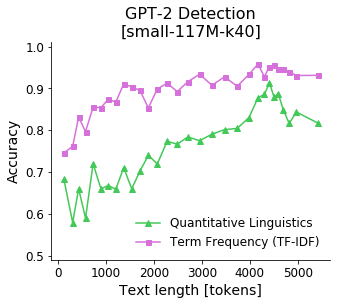

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    *accuracy_by_length_logistic.values.T[::-1],
    marker="^",
    label="Quantitative Linguistics",
    color="#42c957"
)
ax.plot(
    acc_k1.length_m,
    acc_k3.correct,
    label="Term Frequency (TF-IDF)",
    marker="s",
    color="#d670db",
    markersize=5
)
ax.legend(frameon=False)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Text length [tokens]")
ax.set_title(f"GPT-2 Detection\n[{source}]")
ax.set_ylim(0.49, 1.01)
fig.savefig(f"../figures/gpt2-detection-{source}.pdf")

# Prepare data for JSD community

In [25]:
n_train = 10000
n_valid = 5000
source = "xl-1542M"
train_texts, train_labels, valid_texts, valid_labels, test_texts, test_labels = load_data(
    data_dir="../data",
    source=source,
    n_train=n_train,
    n_valid=n_valid)

In [26]:
valid_texts[:2500] = get_gutenberg_pieces([len(x) for x in valid_texts[:2600]])[:2500]
train_texts[:5000] = get_gutenberg_pieces([len(x) for x in train_texts[:5500]])[:5000]
test_texts[:5000] = get_gutenberg_pieces([len(x) for x in test_texts[:5500]])[:5000]

In [27]:
pd.to_pickle({
    "train_texts": train_texts,
    "train_labels": train_labels,
    "test_texts": test_texts,
    "test_labels": test_labels,
    "valid_texts": valid_texts,
    "valid_labels": valid_labels
}, "tmpdata.p")